In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt
# import pca from sklearn
from sklearn.decomposition import PCA

In [2]:
seed = 1

warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      0.1.dev3254+g5b9bc72
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.7
dot_parser                  NA
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
gmpy2                       2.1.2
google                      NA
h5py                        3.10.0
idna                       

In [3]:
sns.set_theme(style="white")

In [4]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [5]:
adata_all = sc.read_h5ad("/home/wu/datb1/reseq_ppp/processed_data/ALL_PPP_10X.h5ad")

adata_all.obs['batch_group'] = adata_all.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_all.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

df_name = adata_all.obs['batch'].astype(str).str.split("_", expand=True)
df_name = df_name[0] + '_' + df_name[1]
# df_name.str.split("C", expand=True)[0]
adata_all.obs['patient'] = df_name.str.split("C", expand=True)[0]
adata_all.write("/home/wu/datb1/reseq_ppp/processed_data/ALL_PPP_10X.h5ad")

In [6]:
adata_all.obs['leiden'] = adata_all.obs['leiden'].cat.reorder_categories(['Keratinocyte I', 'Keratinocyte II', 'Eccrine gland cell (EG)', 'T cell', 'Myeloid cell', 'PPP neutrophil', 
                                                                          'Mast cell', 'Fibroblast (FB)', 'Vascular endothelial cell (VE)', 'Vascular smooth muscle cell (VSM)', 'Neuron', 'Melanocyte'])

In [7]:
adata_all

AnnData object with n_obs × n_vars = 56600 × 18704
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_origin', 'batch_group', 'Meta', 'Gender', 'Age', 'leiden', 'patient'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch', 'batch_colors', 'batch_group_colors', 'batch_origin_colors', 'batch_raw', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata_all

AnnData object with n_obs × n_vars = 56600 × 18704
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_origin', 'batch_group', 'Meta', 'Gender', 'Age', 'leiden', 'patient'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch', 'batch_colors', 'batch_group_colors', 'batch_origin_colors', 'batch_raw', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
df_batch_stats = adata_all.obs.groupby(['batch']).leiden.value_counts().unstack()
df_batch_stats['PPP neutro immune fraction'] = df_batch_stats['PPP neutrophil'] / (df_batch_stats['Myeloid cell'] + df_batch_stats['PPP neutrophil'] + df_batch_stats['Mast cell'] + df_batch_stats['T cell'])
df_batch_stats['PPP neutro mye fraction'] = df_batch_stats['PPP neutrophil'] / (df_batch_stats['Myeloid cell'] + df_batch_stats['PPP neutrophil'])

In [10]:
def extract_batch_group(batch):
    if batch.split('_')[0] == 'PPP':
        if batch.split('_')[1] in ['P18', 'P24', 'P36']:
            return 'Lesion pustule(-)'
        else:
            return 'Lesion pustule(+)'
    elif batch.split('_')[0] == 'HC' or batch.split('_')[0] == 'PPPC':
        return 'HC/NL'
    else:
        assert False, "Unknown batch group"

In [11]:
df_batch_stats['BG'] = df_batch_stats.index.map(extract_batch_group)

In [12]:
df_batch_stats

leiden               Keratinocyte I  Keratinocyte II  Eccrine gland cell (EG)  \
batch                                                                           
HC_HC01_foot_10X                148                6                        6   
HC_HC02_palm_10X               4516             1243                      160   
PPPC_P37C1_palm_10X            1032              180                       83   
PPPC_P37C2_palm_10X            2536              415                       38   
PPPC_P38C1_palm_10X            2111              212                       79   
PPPC_P38C2_palm_10X            2582              251                      113   
PPPC_P39C_palm_10X             2924              278                       99   
PPP_P16_foot_10X                 51                4                        6   
PPP_P17_palm_10X                136                8                        3   
PPP_P18_palm_10X               2428              147                       15   
PPP_P24_foot_10X               1024               47                        6   
PPP_P36_foot_10X               1022              232                      483   
PPP_P37_palm_10X                782              211                       48   
PPP_P38_palm_10X                791               86                       24   
PPP_P39_palm_10X                323               95                        2   
PPP_P40_palm_10X                772              342                       45   

leiden               T cell  Myeloid cell  PPP neutrophil  Mast cell  \
batch                                                                  
HC_HC01_foot_10X        351           245               4        133   
HC_HC02_palm_10X        100            27               0         43   
PPPC_P37C1_palm_10X    1061           574               0        175   
PPPC_P37C2_palm_10X       0             0               0          0   
PPPC_P38C1_palm_10X     696           407               3        109   
PPPC_P38C2_palm_10X     755           402               3        124   
PPPC_P39C_palm_10X      487           364               3         73   
PPP_P16_foot_10X        170           205             215         18   
PPP_P17_palm_10X         42            39              53          8   
PPP_P18_palm_10X        160           130               1         51   
PPP_P24_foot_10X        259           318               4         63   
PPP_P36_foot_10X        841           409             109         92   
PPP_P37_palm_10X        659           690             320         91   
PPP_P38_palm_10X        987           474             400        161   
PPP_P39_palm_10X         83            22             258         10   
PPP_P40_palm_10X       1008           600            2112         83   

leiden               Fibroblast (FB)  Vascular endothelial cell (VE)  \
batch                                                                  
HC_HC01_foot_10X                 197                              66   
HC_HC02_palm_10X                 550                             510   
PPPC_P37C1_palm_10X              202                             138   
PPPC_P37C2_palm_10X              388                             224   
PPPC_P38C1_palm_10X              159                             110   
PPPC_P38C2_palm_10X              164                              93   
PPPC_P39C_palm_10X               291                             215   
PPP_P16_foot_10X                 728                             228   
PPP_P17_palm_10X                 455                             538   
PPP_P18_palm_10X                 147                             696   
PPP_P24_foot_10X                 201                             290   
PPP_P36_foot_10X                 132                             155   
PPP_P37_palm_10X                 114                             106   
PPP_P38_palm_10X                  98                             109   
PPP_P39_palm_10X                  16                             103   
PPP_P40_palm_10X    

In [47]:
from statannotations.Annotator import Annotator

HC/NL vs. Lesion pustule(-): Mann-Whitney-Wilcoxon test two-sided, P_val:9.192e-02 U_stat=2.000e+00
Lesion pustule(-) vs. Lesion pustule(+): Mann-Whitney-Wilcoxon test two-sided, P_val:2.381e-02 U_stat=0.000e+00
HC/NL vs. Lesion pustule(+): Mann-Whitney-Wilcoxon test two-sided, P_val:4.998e-03 U_stat=0.000e+00
HC/NL vs. Lesion pustule(-): Mann-Whitney-Wilcoxon test two-sided, P_val:1.539e-01 U_stat=3.000e+00
Lesion pustule(-) vs. Lesion pustule(+): Mann-Whitney-Wilcoxon test two-sided, P_val:2.381e-02 U_stat=0.000e+00
HC/NL vs. Lesion pustule(+): Mann-Whitney-Wilcoxon test two-sided, P_val:4.998e-03 U_stat=0.000e+00


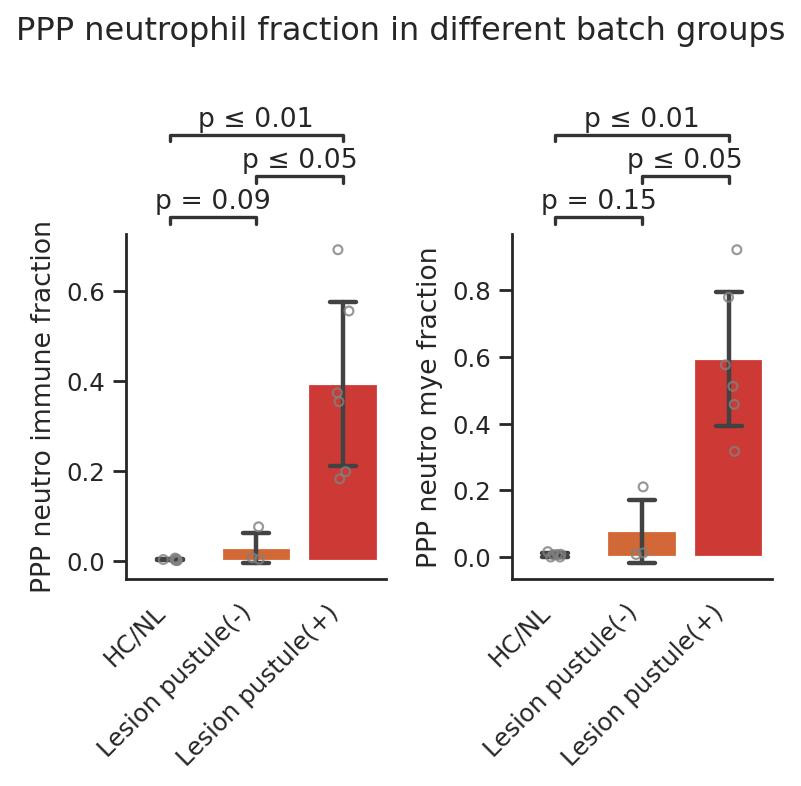

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
order = ['HC/NL', 'Lesion pustule(-)', 'Lesion pustule(+)']
pairs = [('HC/NL', 'Lesion pustule(-)'), ('HC/NL', 'Lesion pustule(+)'), ('Lesion pustule(-)', 'Lesion pustule(+)')]

for i, fraction in enumerate(['PPP neutro immune fraction', 'PPP neutro mye fraction']):
    sns.barplot(x='BG', y=fraction, data=df_batch_stats, ax=ax[i], order=order, ci="sd", 
                capsize=0.3, errwidth=2, dodge=True, palette=['black', '#EB5F1B', '#E7211A'])
    sns.stripplot(x=df_batch_stats['BG'], y=df_batch_stats[fraction], ax=ax[i], size=5, alpha=0.8, color='gray', marker="$\circ$", order=order)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[i].yaxis.set_ticks_position('left')
    annotator = Annotator(ax[i], pairs=pairs, data=df_batch_stats, x='BG', y=fraction, order=order)
    annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()
sns.despine()
fig.tight_layout()
fig.suptitle('PPP neutrophil fraction in different batch groups')
plt.savefig('figures/fig1/ppp_fraction_in_immune.pdf')

<Axes: xlabel='BG', ylabel='PPP neutro mye fraction'>

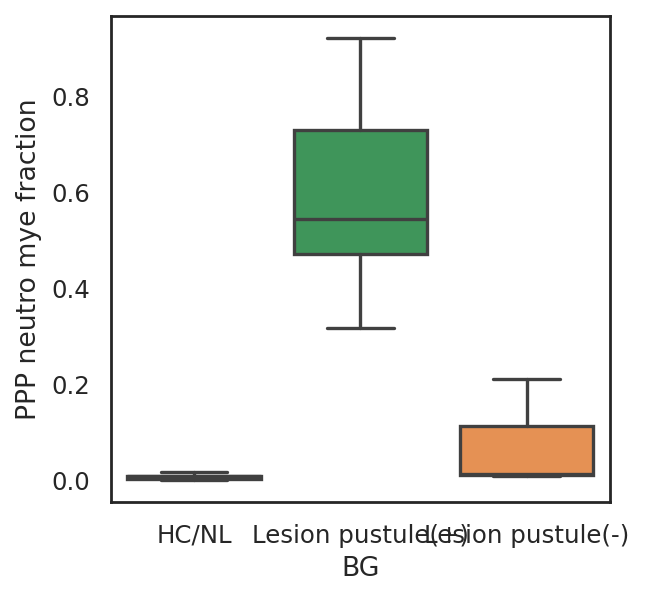

In [46]:
sns.boxplot(data=df_batch_stats, x='BG', y='PPP neutro mye fraction', palette=['#3182bd', '#31a354', '#fd8d3c'])

In [44]:
df_batch_stats

leiden               Keratinocyte I  Keratinocyte II  Eccrine gland cell (EG)  \
batch                                                                           
HC_HC01_foot_10X                148                6                        6   
HC_HC02_palm_10X               4516             1243                      160   
PPPC_P37C1_palm_10X            1032              180                       83   
PPPC_P37C2_palm_10X            2536              415                       38   
PPPC_P38C1_palm_10X            2111              212                       79   
PPPC_P38C2_palm_10X            2582              251                      113   
PPPC_P39C_palm_10X             2924              278                       99   
PPP_P16_foot_10X                 51                4                        6   
PPP_P17_palm_10X                136                8                        3   
PPP_P18_palm_10X               2428              147                       15   
PPP_P24_foot_10X               1024               47                        6   
PPP_P36_foot_10X               1022              232                      483   
PPP_P37_palm_10X                782              211                       48   
PPP_P38_palm_10X                791               86                       24   
PPP_P39_palm_10X                323               95                        2   
PPP_P40_palm_10X                772              342                       45   

leiden               T cell  Myeloid cell  PPP neutrophil  Mast cell  \
batch                                                                  
HC_HC01_foot_10X        351           245               4        133   
HC_HC02_palm_10X        100            27               0         43   
PPPC_P37C1_palm_10X    1061           574               0        175   
PPPC_P37C2_palm_10X       0             0               0          0   
PPPC_P38C1_palm_10X     696           407               3        109   
PPPC_P38C2_palm_10X     755           402               3        124   
PPPC_P39C_palm_10X      487           364               3         73   
PPP_P16_foot_10X        170           205             215         18   
PPP_P17_palm_10X         42            39              53          8   
PPP_P18_palm_10X        160           130               1         51   
PPP_P24_foot_10X        259           318               4         63   
PPP_P36_foot_10X        841           409             109         92   
PPP_P37_palm_10X        659           690             320         91   
PPP_P38_palm_10X        987           474             400        161   
PPP_P39_palm_10X         83            22             258         10   
PPP_P40_palm_10X       1008           600            2112         83   

leiden               Fibroblast (FB)  Vascular endothelial cell (VE)  \
batch                                                                  
HC_HC01_foot_10X                 197                              66   
HC_HC02_palm_10X                 550                             510   
PPPC_P37C1_palm_10X              202                             138   
PPPC_P37C2_palm_10X              388                             224   
PPPC_P38C1_palm_10X              159                             110   
PPPC_P38C2_palm_10X              164                              93   
PPPC_P39C_palm_10X               291                             215   
PPP_P16_foot_10X                 728                             228   
PPP_P17_palm_10X                 455                             538   
PPP_P18_palm_10X                 147                             696   
PPP_P24_foot_10X                 201                             290   
PPP_P36_foot_10X                 132                             155   
PPP_P37_palm_10X                 114                             106   
PPP_P38_palm_10X                  98                             109   
PPP_P39_palm_10X                  16                             103   
PPP_P40_palm_10X    

### Plot Landscape and metadata

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


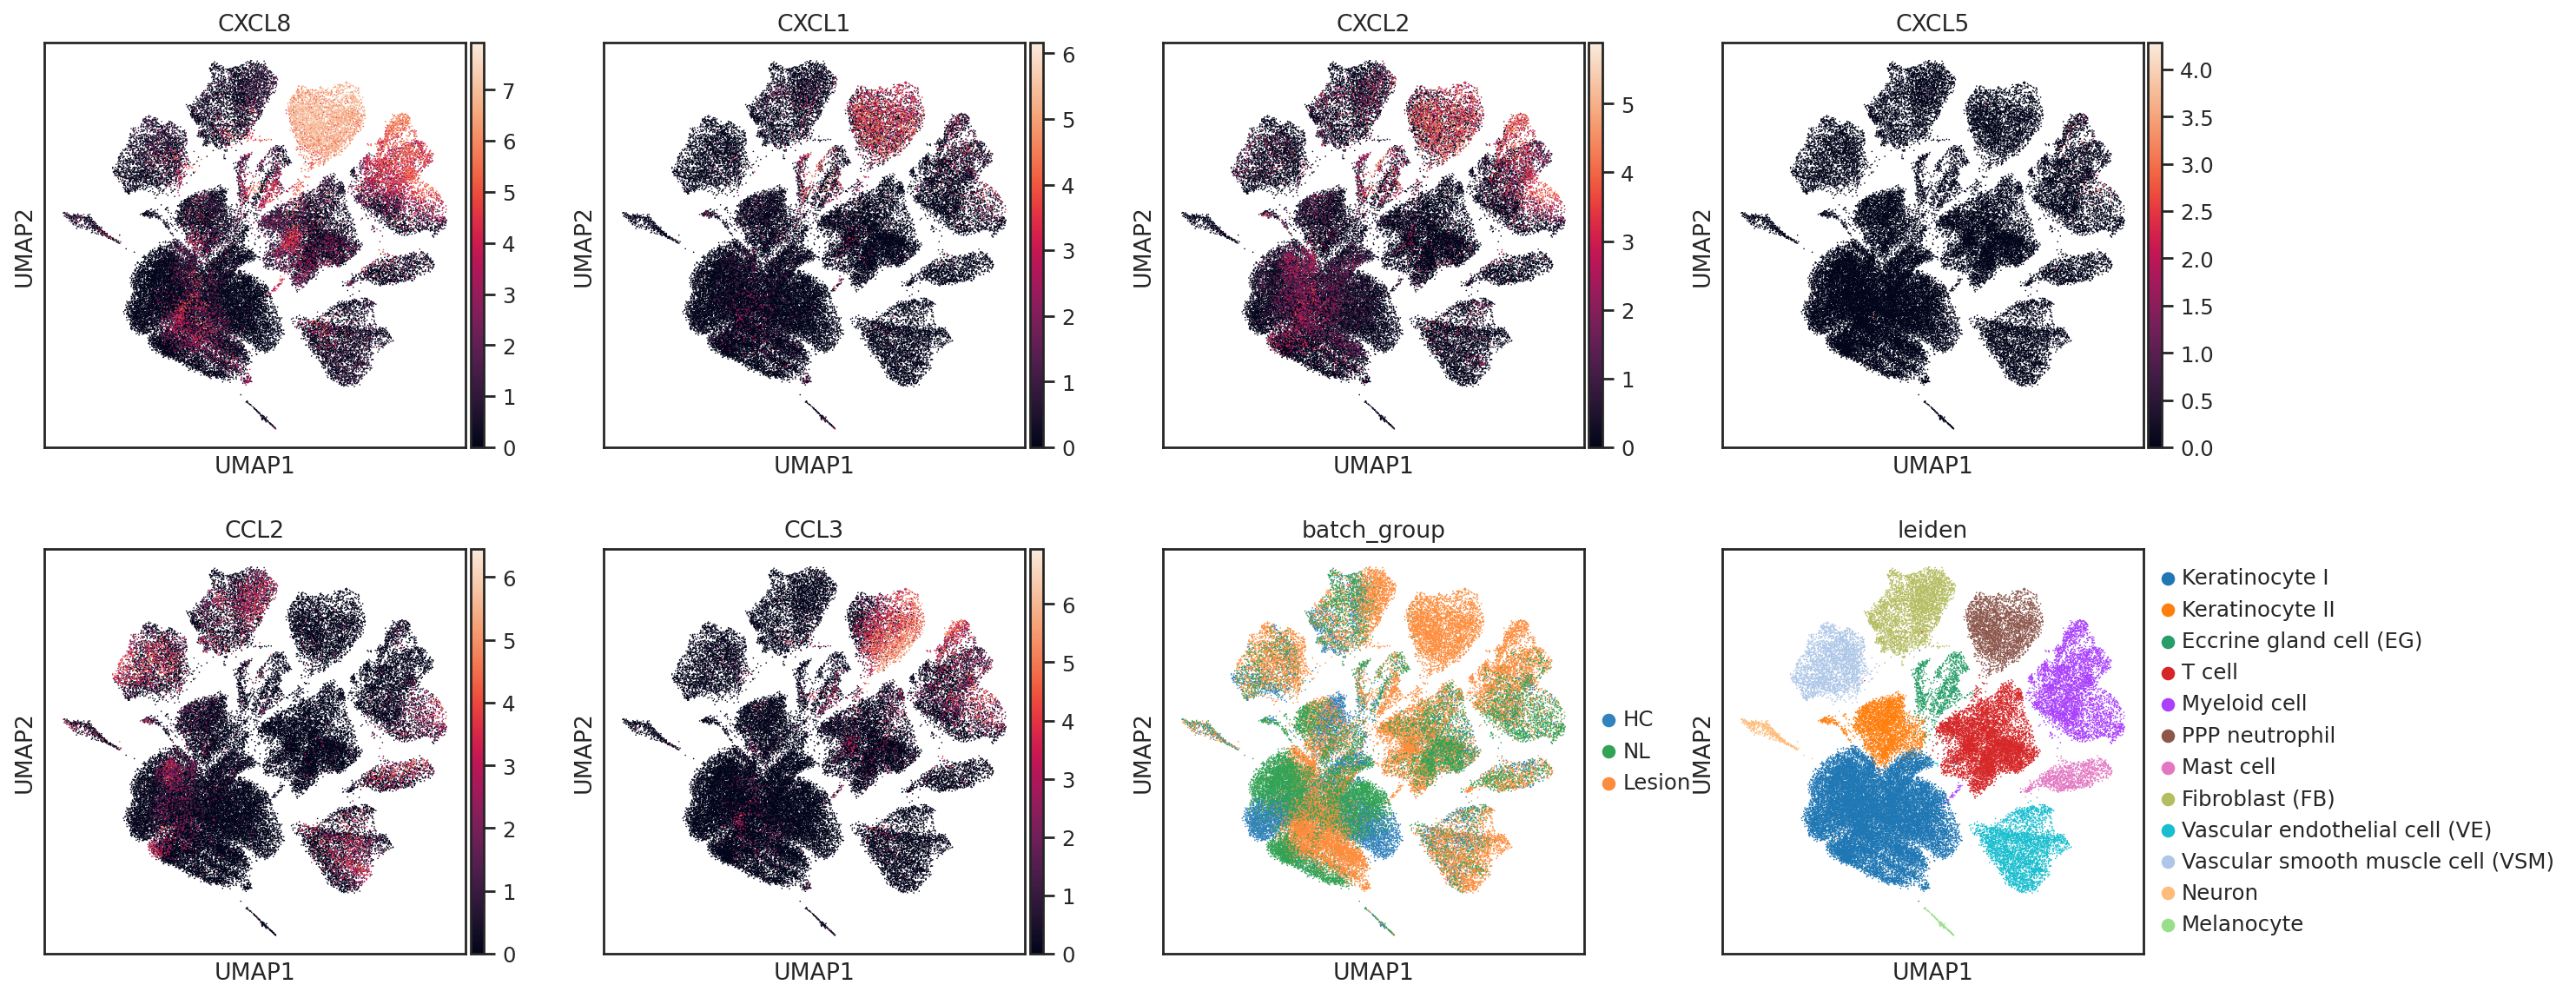

In [8]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_all, color=['CXCL8', 'CXCL1', 'CXCL2', 'CXCL5', 'CCL2', 'CCL3', 'batch_group', 'leiden'], ncols=4)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


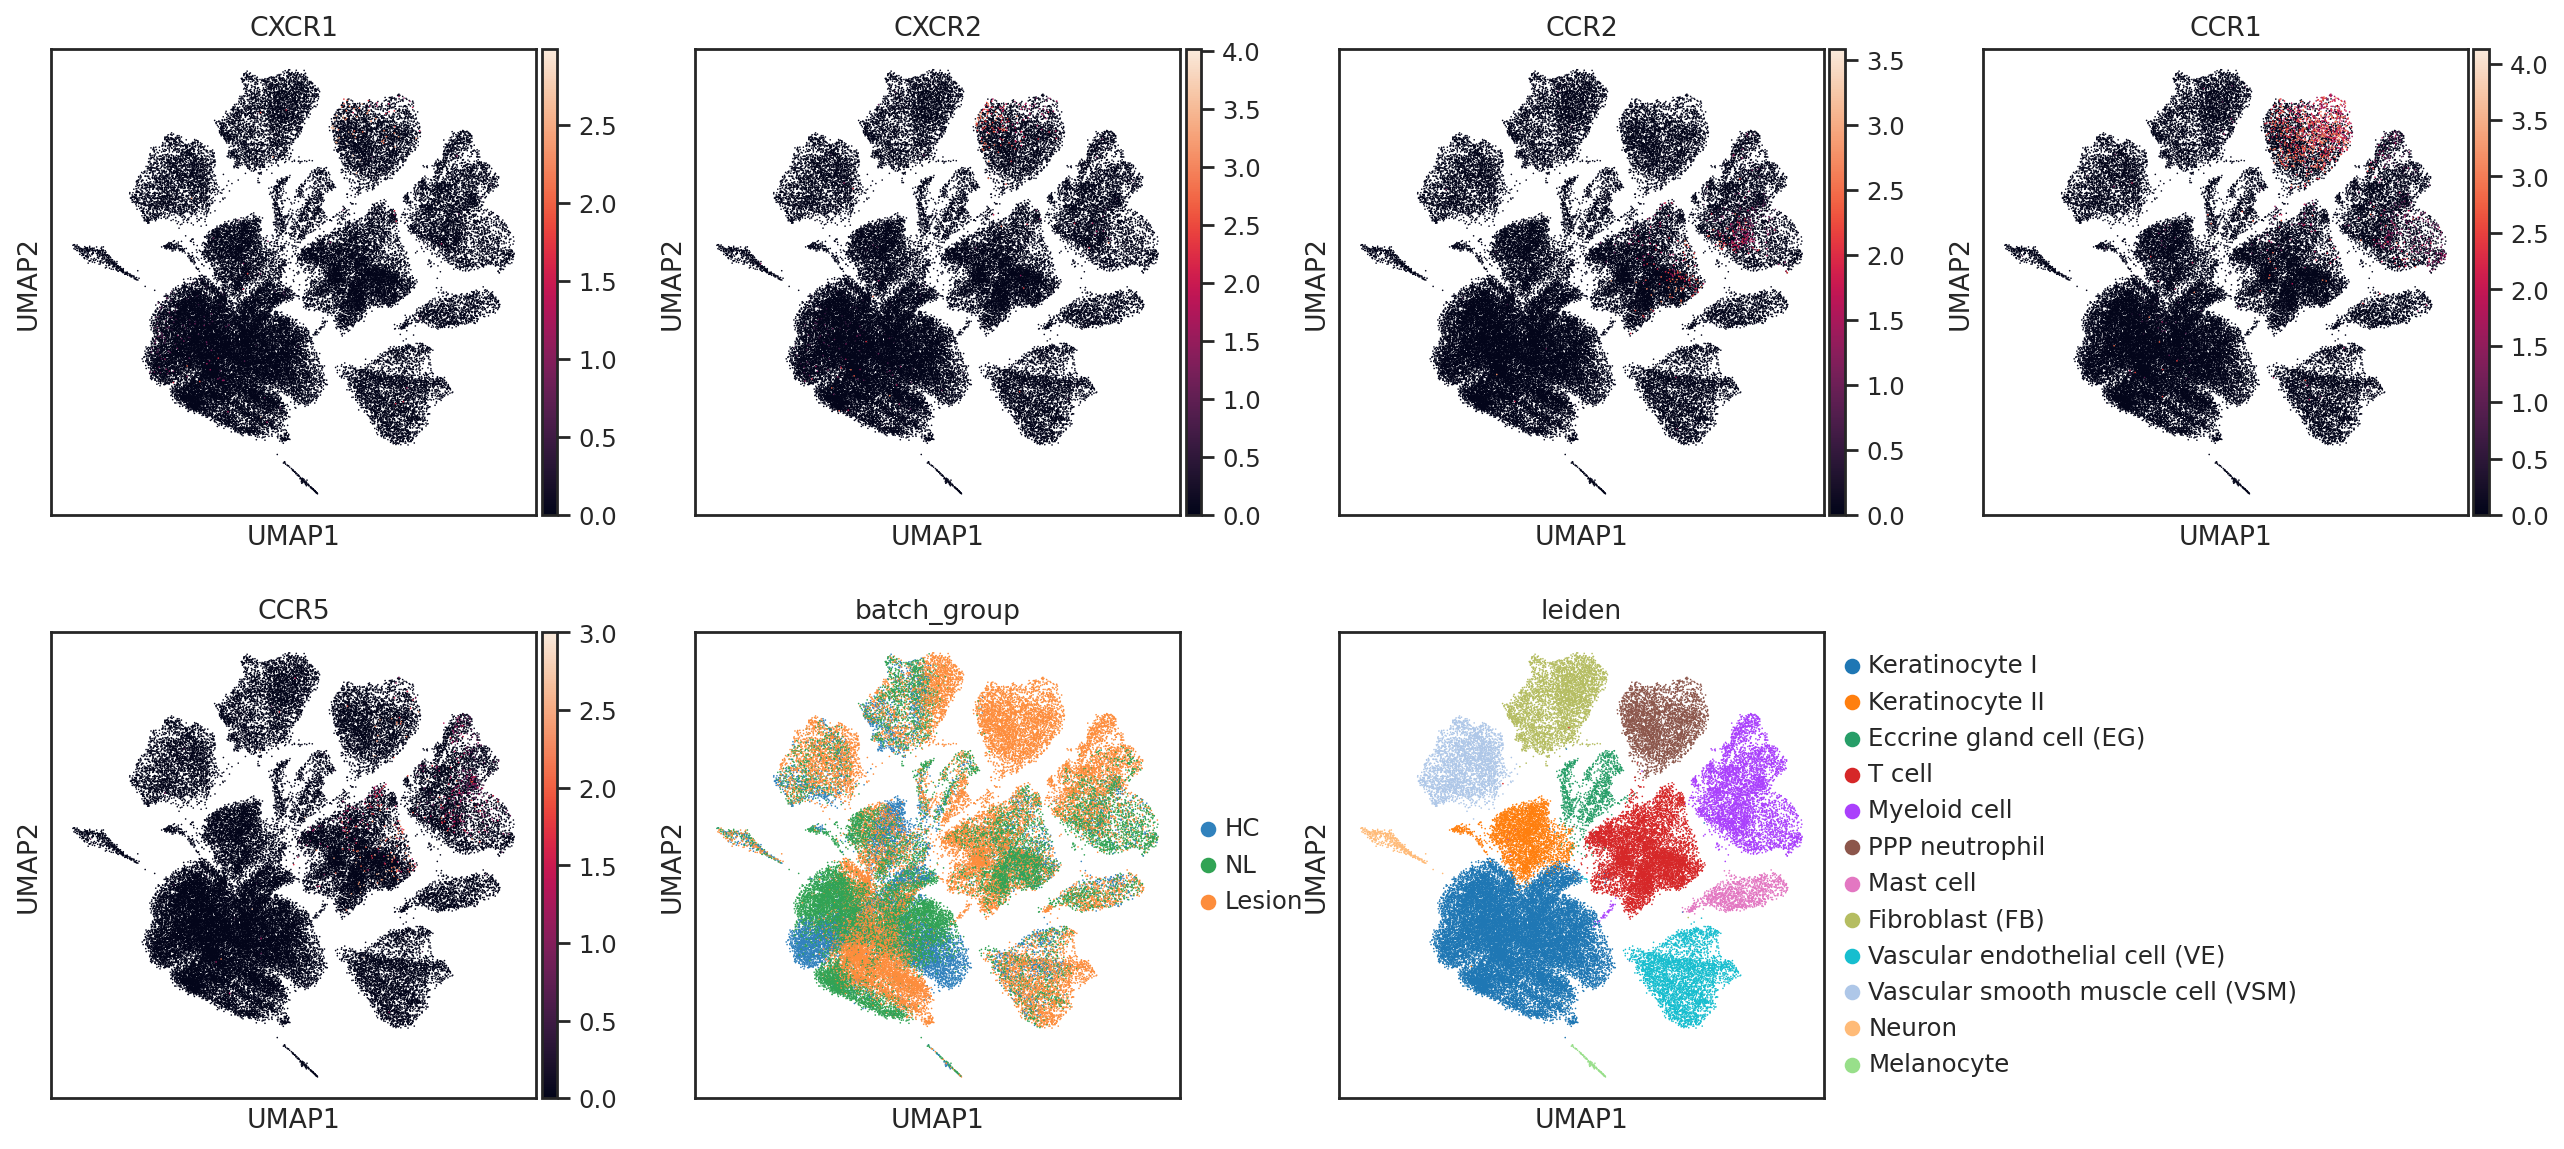

In [15]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_all, color=['CXCR1', 'CXCR2', 'CCR2', 'CCR1', 'CCR5', 'batch_group', 'leiden'], ncols=4)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


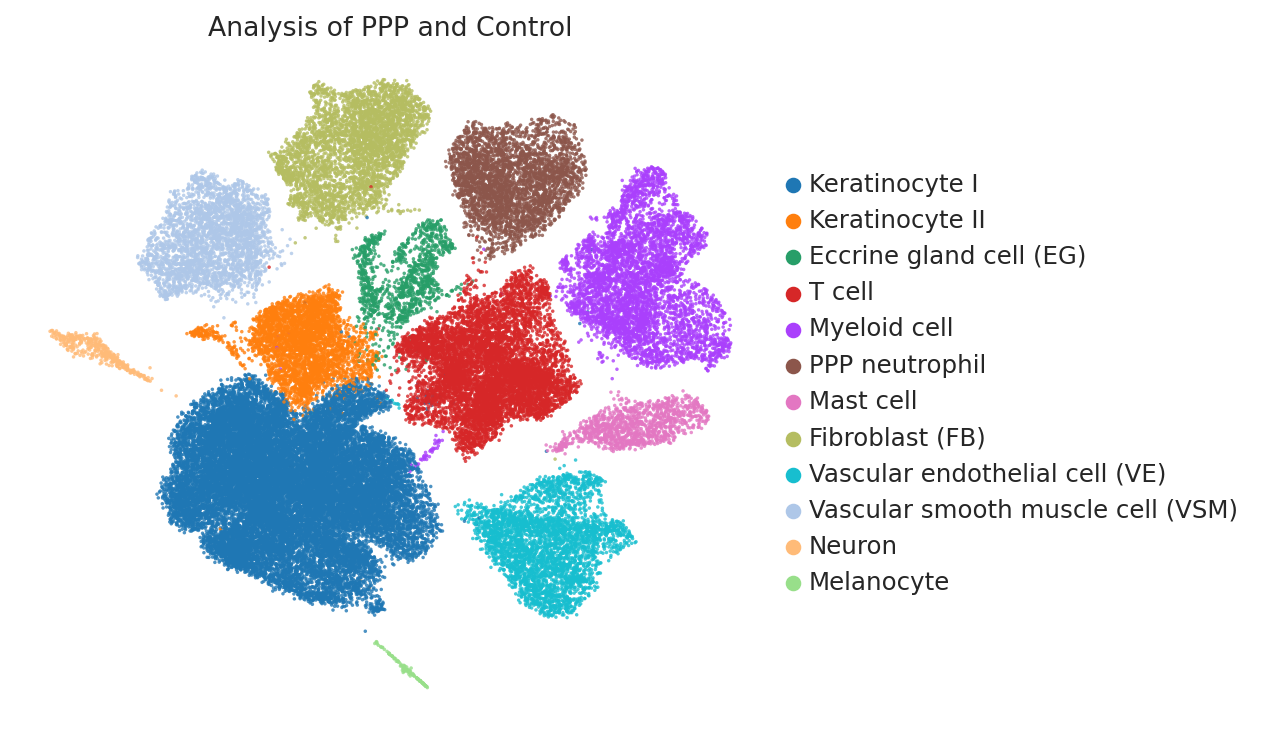

In [8]:
# plot figure
with rc_context({'figure.figsize': (6, 5.5)}):
    ax = sc.pl.umap(adata_all, color=['leiden'], show=False, frameon=False, size=10, alpha=0.8)
    # set ax x and y label
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.title("Analysis of PPP and Control")
    plt.savefig('figures/fig1/sc_merge_ppp_with_control.pdf', bbox_inches="tight")
    plt.show()

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:376: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


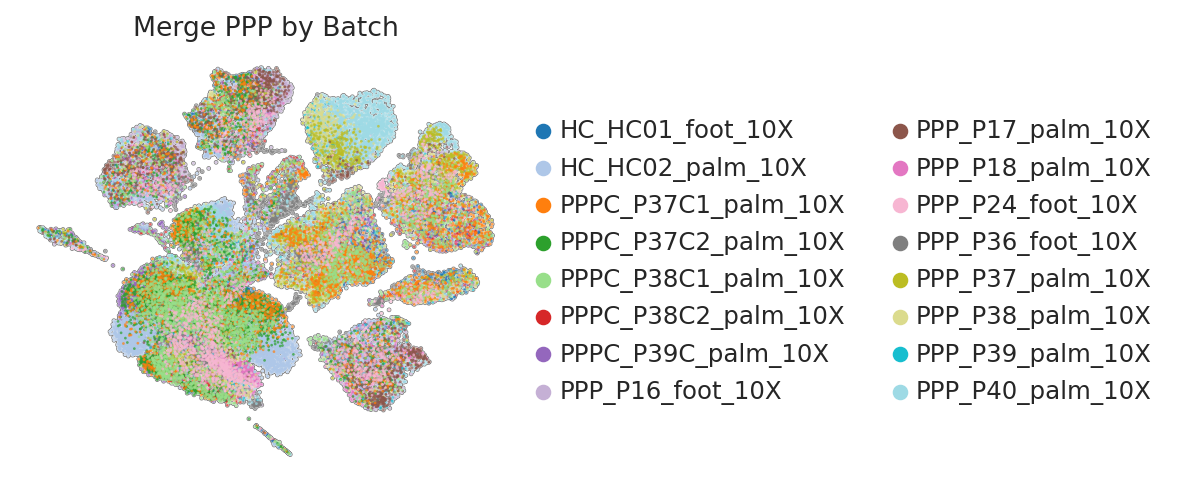

In [9]:
with rc_context({'figure.figsize': (4, 3.5)}):
    ax = sc.pl.umap(adata_all, color=['batch'], show=False, frameon=False, size=6, alpha=0.7, palette='tab20',
                    add_outline=True, outline_color=('grey', 'white'))
    # set ax x and y label
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.title("Merge PPP by Batch")
    plt.savefig('figures/fig1/sc_merge_ppp_with_control_batch.pdf', bbox_inches="tight")
    plt.show()

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:376: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


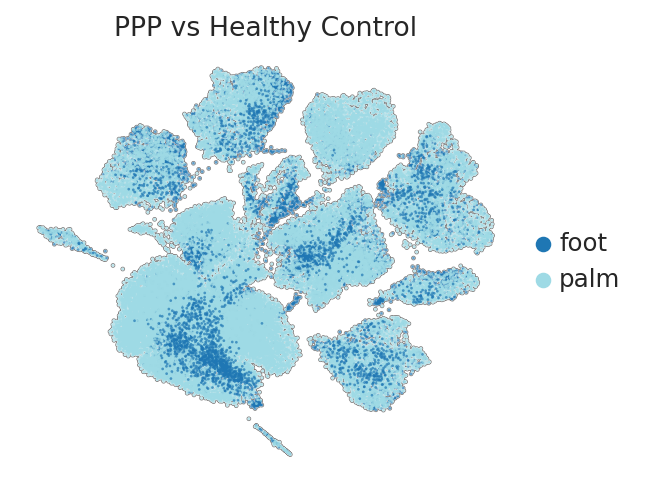

In [10]:
with rc_context({'figure.figsize': (4, 3.5)}):
    ax = sc.pl.umap(adata_all, color=['batch_origin'], show=False, frameon=False, size=6, alpha=0.7, palette='tab20',
                    add_outline=True, outline_color=('grey', 'white'))
    # set ax x and y label
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.title("PPP vs Healthy Control")
    plt.savefig('figures/fig1/sc_merge_ppp_with_control_batch_origin.pdf', bbox_inches="tight")
    plt.show()

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:376: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


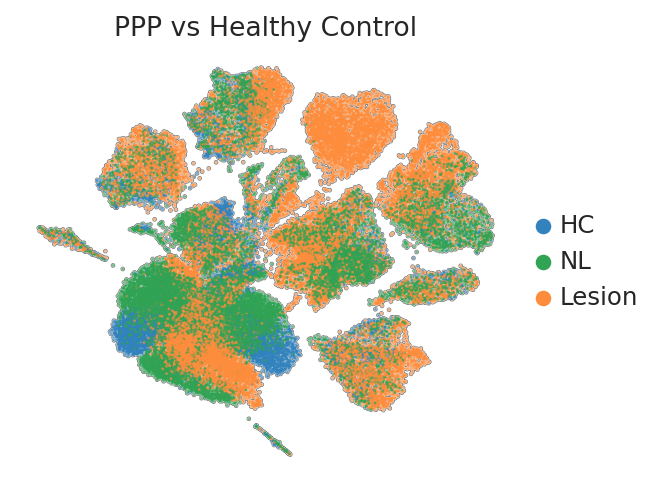

In [11]:
with rc_context({'figure.figsize': (4, 3.5)}):
    ax = sc.pl.umap(adata_all, color=['batch_group'], show=False, frameon=False, size=6, alpha=0.7, add_outline=True, outline_color=('grey', 'white'))
    # set ax x and y label
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.title("PPP vs Healthy Control")
    plt.savefig('figures/fig1/sc_merge_ppp_with_control_batch_group.pdf', bbox_inches="tight")
    plt.show()

### Plot Marker genes

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


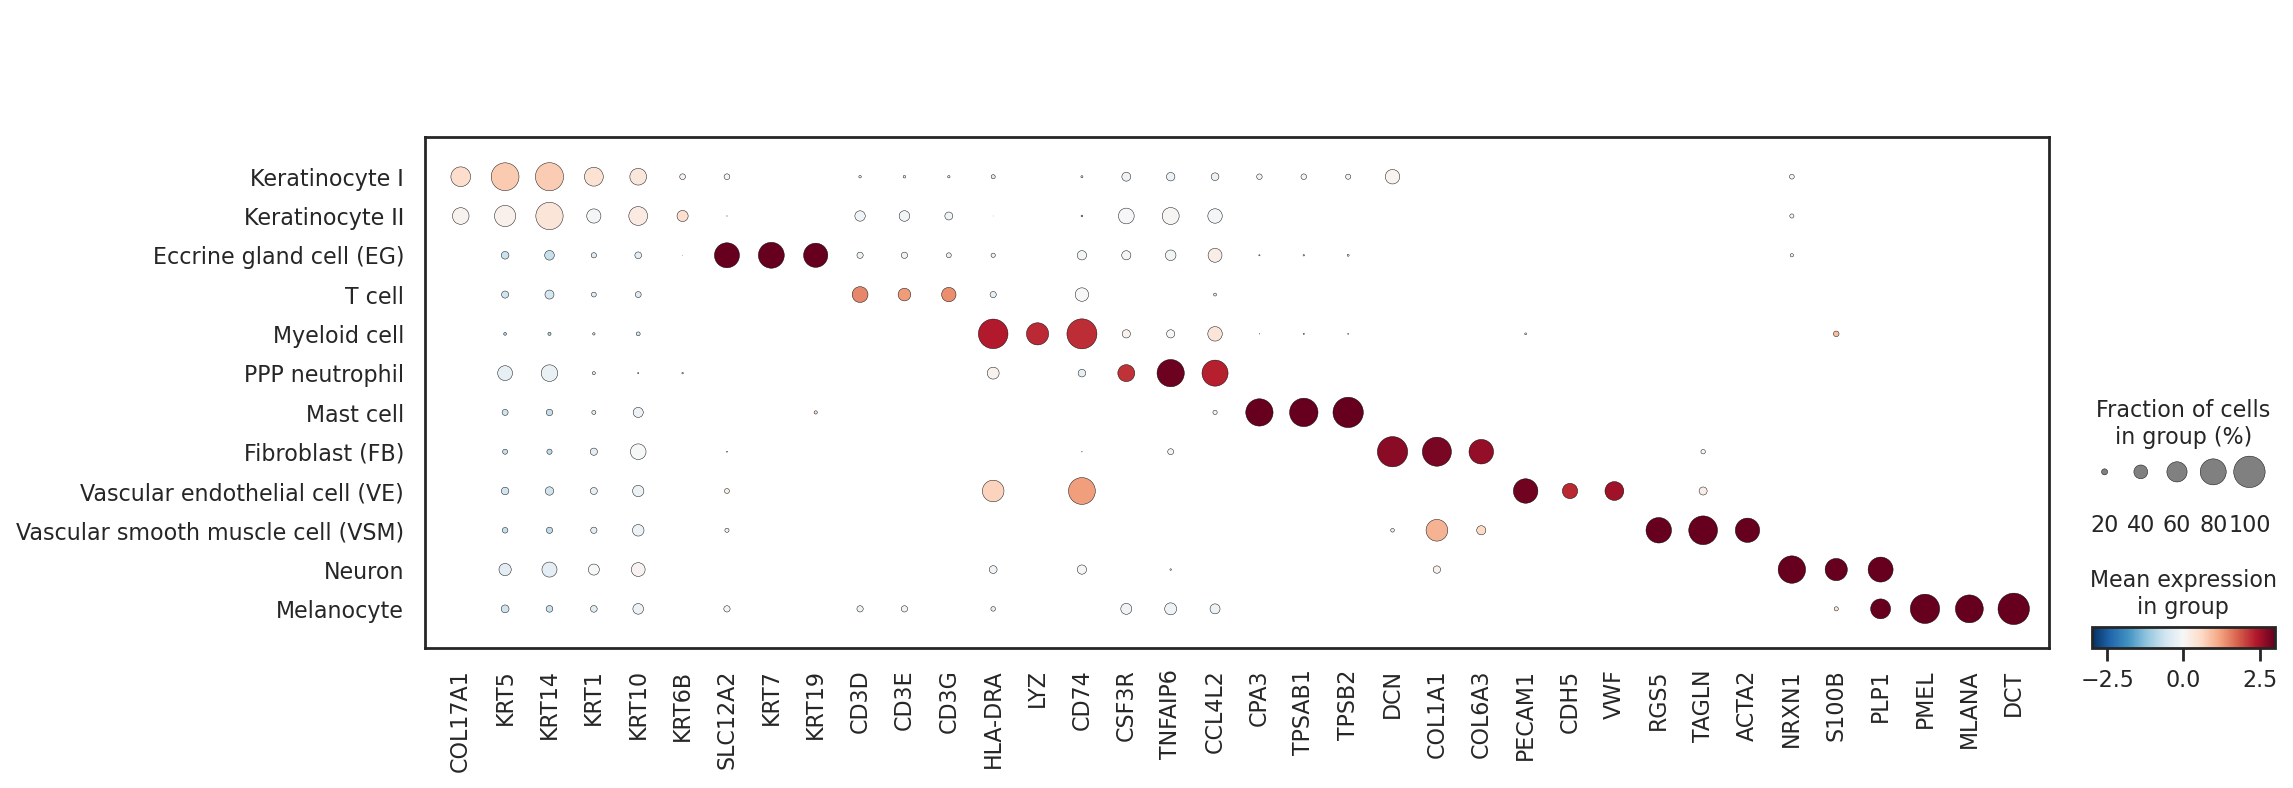

In [12]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "SLC12A2", "KRT7", "KRT19","CD3D","CD3E","CD3G",
                "HLA-DRA", "LYZ", "CD74", "CSF3R", "TNFAIP6","CCL4L2","CPA3","TPSAB1","TPSB2",
                "DCN","COL1A1","COL6A3","PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2",
                "NRXN1","S100B","PLP1","PMEL", "MLANA", "DCT"]

with rc_context({'figure.figsize': (8, 7)}):
    sc.pl.dotplot(adata_all, marker_genes, groupby='leiden', show=False, use_raw=False, dot_max=1, dot_min=0.1, color_map='RdBu_r', vmax=3, vmin=-3)
    plt.savefig('figures/fig1/dot_marker_genes.pdf', bbox_inches="tight")
    plt.show()

### Plot DE gene number in clusters

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:40)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Keratinocyte I has 812 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
Cluster Keratinocyte II has 164 DE genes
ranking genes


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Eccrine gland cell (EG) has 93 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster T cell has 524 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Myeloid cell has 589 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
Cluster PPP neutrophil has 1 DE genes
ranking genes


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Mast cell has 22 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Fibroblast (FB) has 463 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Vascular endothelial cell (VE) has 297 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
Cluster Vascular smooth muscle cell (VSM) has 233 DE genes
ranking genes


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Cluster Neuron has 10 DE genes
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
/home/wu/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


Cluster Melanocyte has 3 DE genes


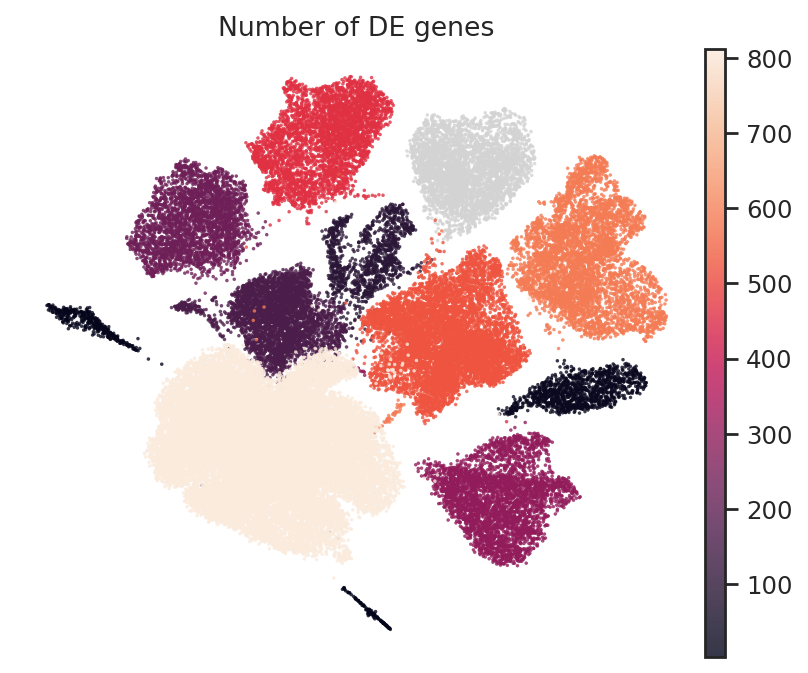

In [13]:
# examine diff expression of each cluster
for cluster in adata_all.obs.leiden.cat.categories:
    _adata = adata_all[adata_all.obs.leiden == cluster].copy()
    sc.tl.rank_genes_groups(_adata, groupby='Meta', groups=['Lesion'], method='wilcoxon', use_raw=True, tie_correct=True,
                            n_genes=20000)
    diff_exp_cluster_df = sc.get.rank_genes_groups_df(_adata, group='Lesion', pval_cutoff=1e-4, log2fc_min=1)
    adata_all.obs.loc[_adata.obs.index, 'Lesion_DE'] = diff_exp_cluster_df.shape[0]
    print(f"Cluster {cluster} has {diff_exp_cluster_df.shape[0]} DE genes")
    
frac_series = adata_all.obs[adata_all.obs.Meta == 'Lesion'].groupby('leiden').Meta.count() / adata_all.obs.groupby('leiden').Meta.count()
exclude_list = frac_series[(frac_series > 0.9) | (frac_series < 0.1)].index.tolist()
for cluster in adata_all.obs.leiden.cat.categories:
    if cluster in exclude_list:
        adata_all.obs.loc[adata_all.obs.leiden == cluster, 'Lesion_DE'] = np.nan

# plot figure
with rc_context({'figure.figsize': (6, 5)}):
    ax = sc.pl.umap(adata_all, color=['Lesion_DE'], show=False, frameon=False, size=10, alpha=0.8)
    # set ax x and y label
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.title("Number of DE genes")
    plt.savefig('figures/fig1/sc_merge_ppp_deg_number.pdf', bbox_inches="tight")
    plt.show()

### Plot Group fraction (Total)

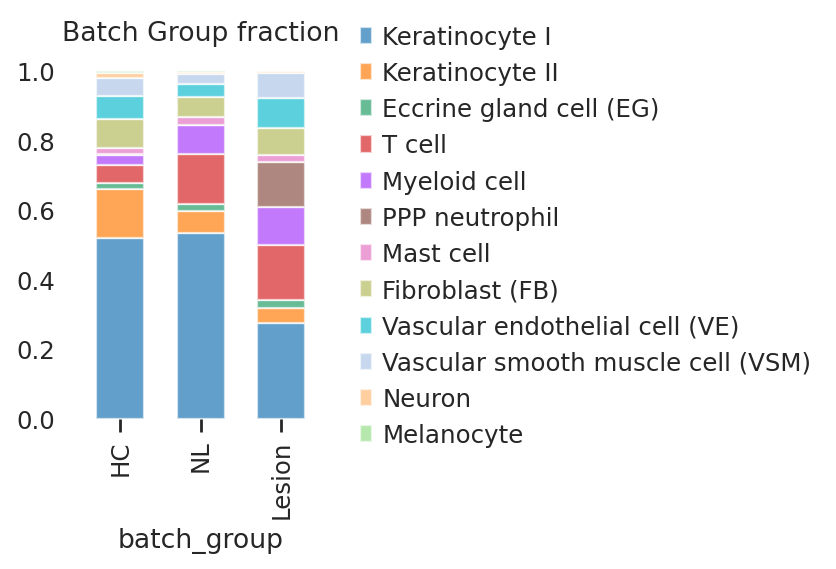

In [14]:
sns.set_theme(style="white")

# plot figure
with rc_context({'figure.figsize': (2, 3)}):
    ax = (adata_all.obs.groupby(['leiden', 'batch_group']).size() / adata_all.obs.groupby('batch_group').size()).unstack().T \
        .plot.bar(stacked=True, color=adata_all.uns['leiden_colors'], width=0.6, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title("Batch Group fraction")
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.savefig('figures/fig1/ppp_group_fraction.pdf', bbox_inches="tight")
    plt.show()

### Metadata

In [15]:
adata_all.obs['leiden'] = adata_all.obs['leiden'].cat.reorder_categories(['Keratinocyte I', 'Keratinocyte II', 'Eccrine gland cell (EG)', 'T cell', 'Myeloid cell', 'PPP neutrophil', 
                                                                          'Mast cell', 'Fibroblast (FB)', 'Vascular endothelial cell (VE)', 'Vascular smooth muscle cell (VSM)', 'Neuron', 'Melanocyte'][::-1])

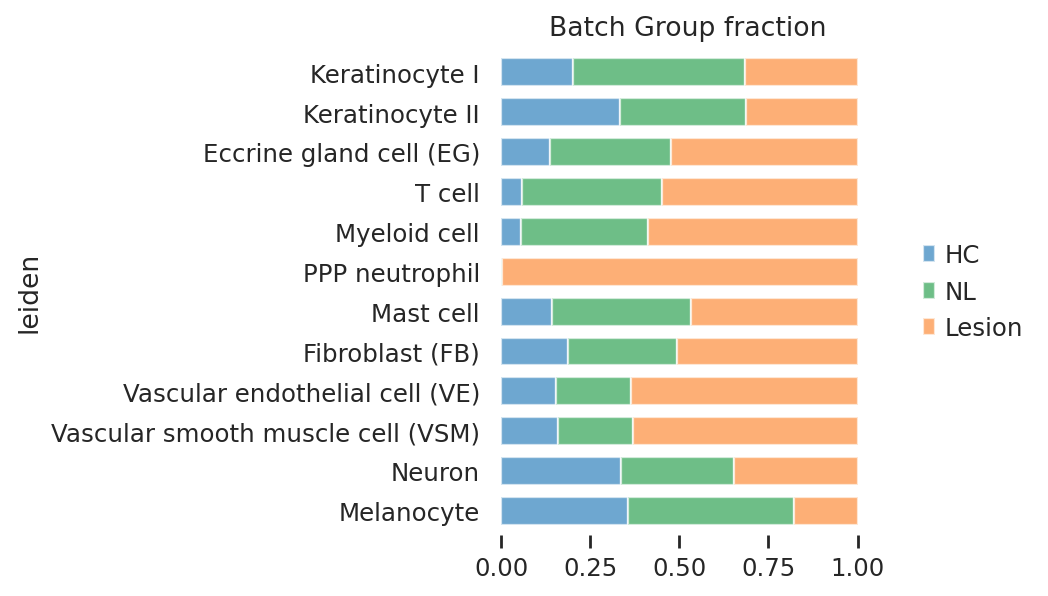

In [16]:
adata_all.obs['batch_group'] = adata_all.obs.batch_group.astype('category').cat.reorder_categories(['HC', 'NL', 'Lesion'])
# adata_all.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']
# plot figure
with rc_context({'figure.figsize': (3, 4)}):
    ax = (adata_all.obs.groupby(['leiden', 'batch_group']).size() / adata_all.obs.groupby('leiden').size()).unstack() \
        .plot.barh(stacked=True, color=adata_all.uns['batch_group_colors'], width=0.7, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title("Batch Group fraction")
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.savefig('figures/fig1/barh_0_merge_ppp_with_control_group_fraction.pdf', bbox_inches="tight")
    plt.show()

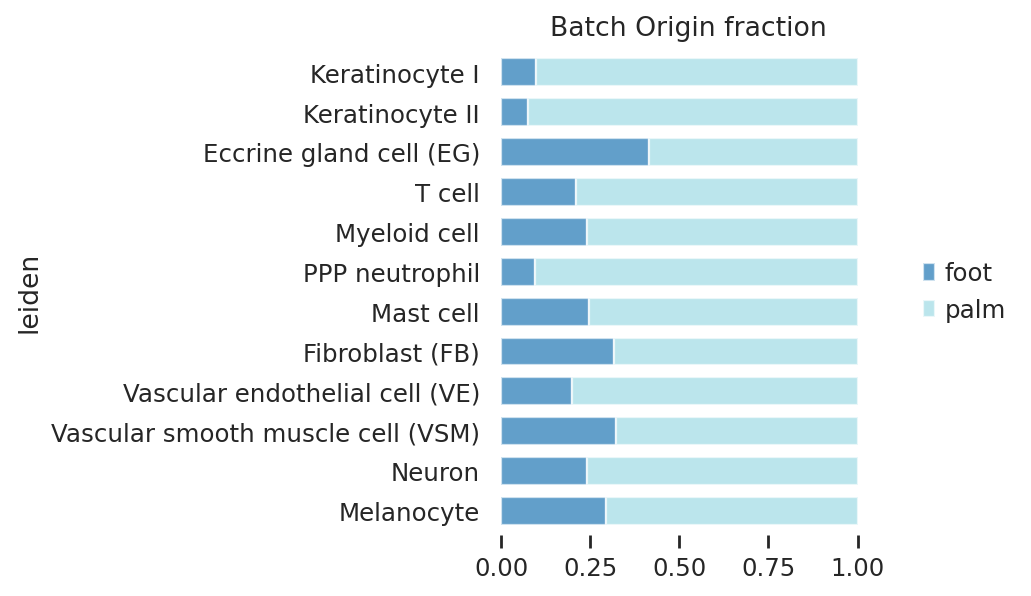

In [17]:
adata_all.obs['batch_origin'] = adata_all.obs['batch_origin'].astype('str')
# plot figure
with rc_context({'figure.figsize': (3, 4)}):
    ax = (adata_all.obs.groupby(['leiden', 'batch_origin']).size() / adata_all.obs.groupby('leiden').size()).unstack() \
        .plot.barh(stacked=True, color=[sns.color_palette("tab20")[i] for i in (0,-1)], width=0.7, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title("Batch Origin fraction")
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.savefig('figures/fig1/barh_1_merge_ppp_with_control_origin_fraction.pdf', bbox_inches="tight")
    plt.show()

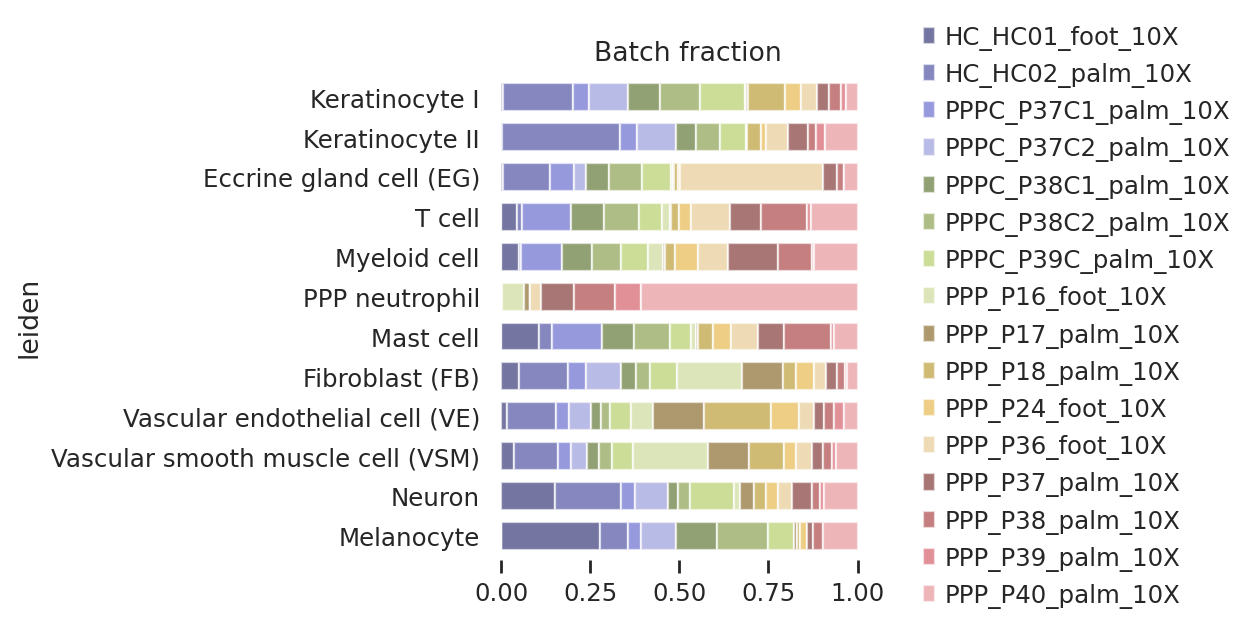

In [18]:
adata_all.obs['batch'] = adata_all.obs['batch'].astype('str')
# plot figure
with rc_context({'figure.figsize': (3, 4)}):
    ax = (adata_all.obs.groupby(['leiden', 'batch']).size() / adata_all.obs.groupby('leiden').size()).unstack() \
        .plot.barh(stacked=True, color=sns.color_palette("tab20b"), width=0.7, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.title("Batch fraction")
    plt.savefig('figures/fig1/barh_2_merge_ppp_with_control_batch_fraction.pdf', bbox_inches="tight")

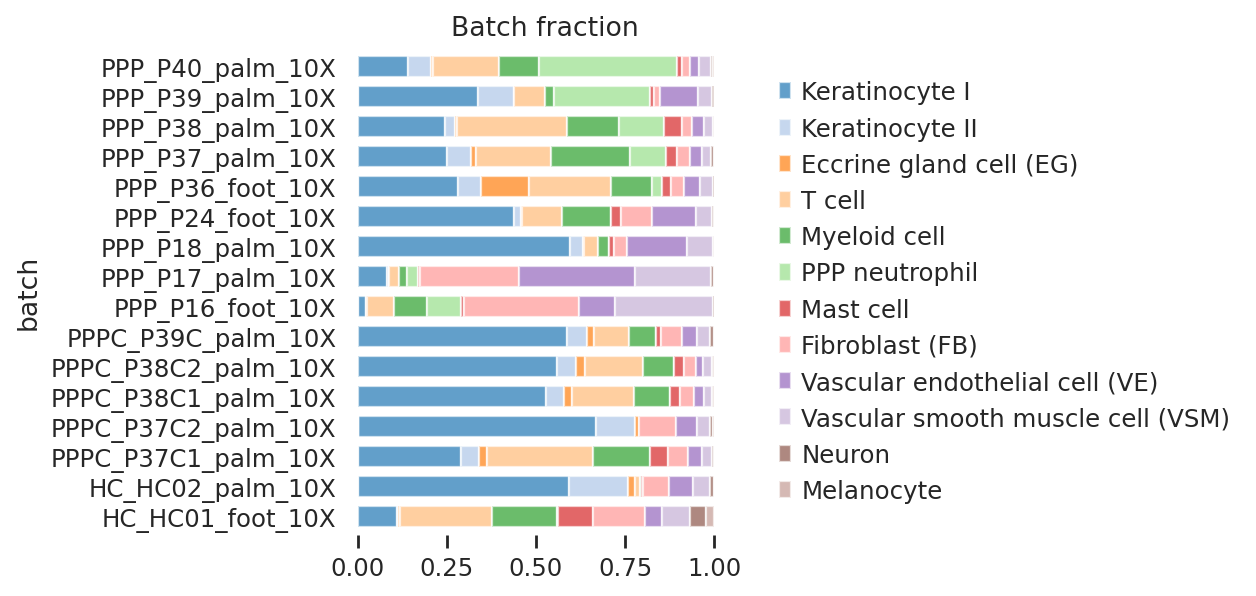

In [39]:
adata_all.obs['batch'] = adata_all.obs['batch'].astype('str')
# plot figure
with rc_context({'figure.figsize': (3, 4)}):
    ax = (adata_all.obs.groupby(['batch', 'leiden']).size() / adata_all.obs.groupby('batch').size()).unstack() \
        .plot.barh(stacked=True, color=sns.color_palette("tab20"), width=0.7, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.title("Batch fraction")
    # plt.savefig('figures/fig1/barh_2_merge_ppp_with_control_batch_fraction.pdf', bbox_inches="tight")

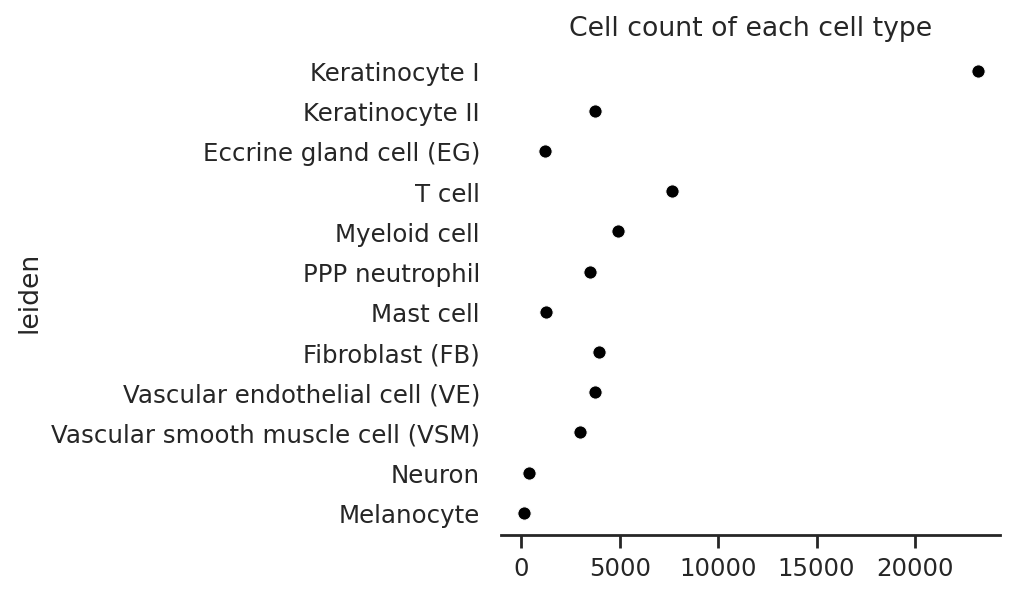

In [19]:
adata_all.obs['leiden'] = adata_all.obs['leiden'].cat.reorder_categories(['Keratinocyte I', 'Keratinocyte II', 'Eccrine gland cell (EG)', 'T cell', 'Myeloid cell', 'PPP neutrophil', 
                                                                          'Mast cell', 'Fibroblast (FB)', 'Vascular endothelial cell (VE)', 'Vascular smooth muscle cell (VSM)', 'Neuron', 'Melanocyte'])

with rc_context({'figure.figsize': (4, 4)}):
    ax = sns.scatterplot(y=adata_all.obs.groupby('leiden').size().index, x=adata_all.obs.groupby('leiden').size().values, color='black')
    # ax.set_xscale('log')
    sns.despine(left=True)
    plt.tick_params(top=False,bottom=True,left=False,right=False)
    plt.title("Cell count of each cell type")
    plt.savefig('figures/fig1/doth_3_merge_ppp_with_control_count.pdf', bbox_inches="tight")

### QC stats

/tmp/ipykernel_1487340/1339079815.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['{:,.0%}'.format(x) for x in vals])


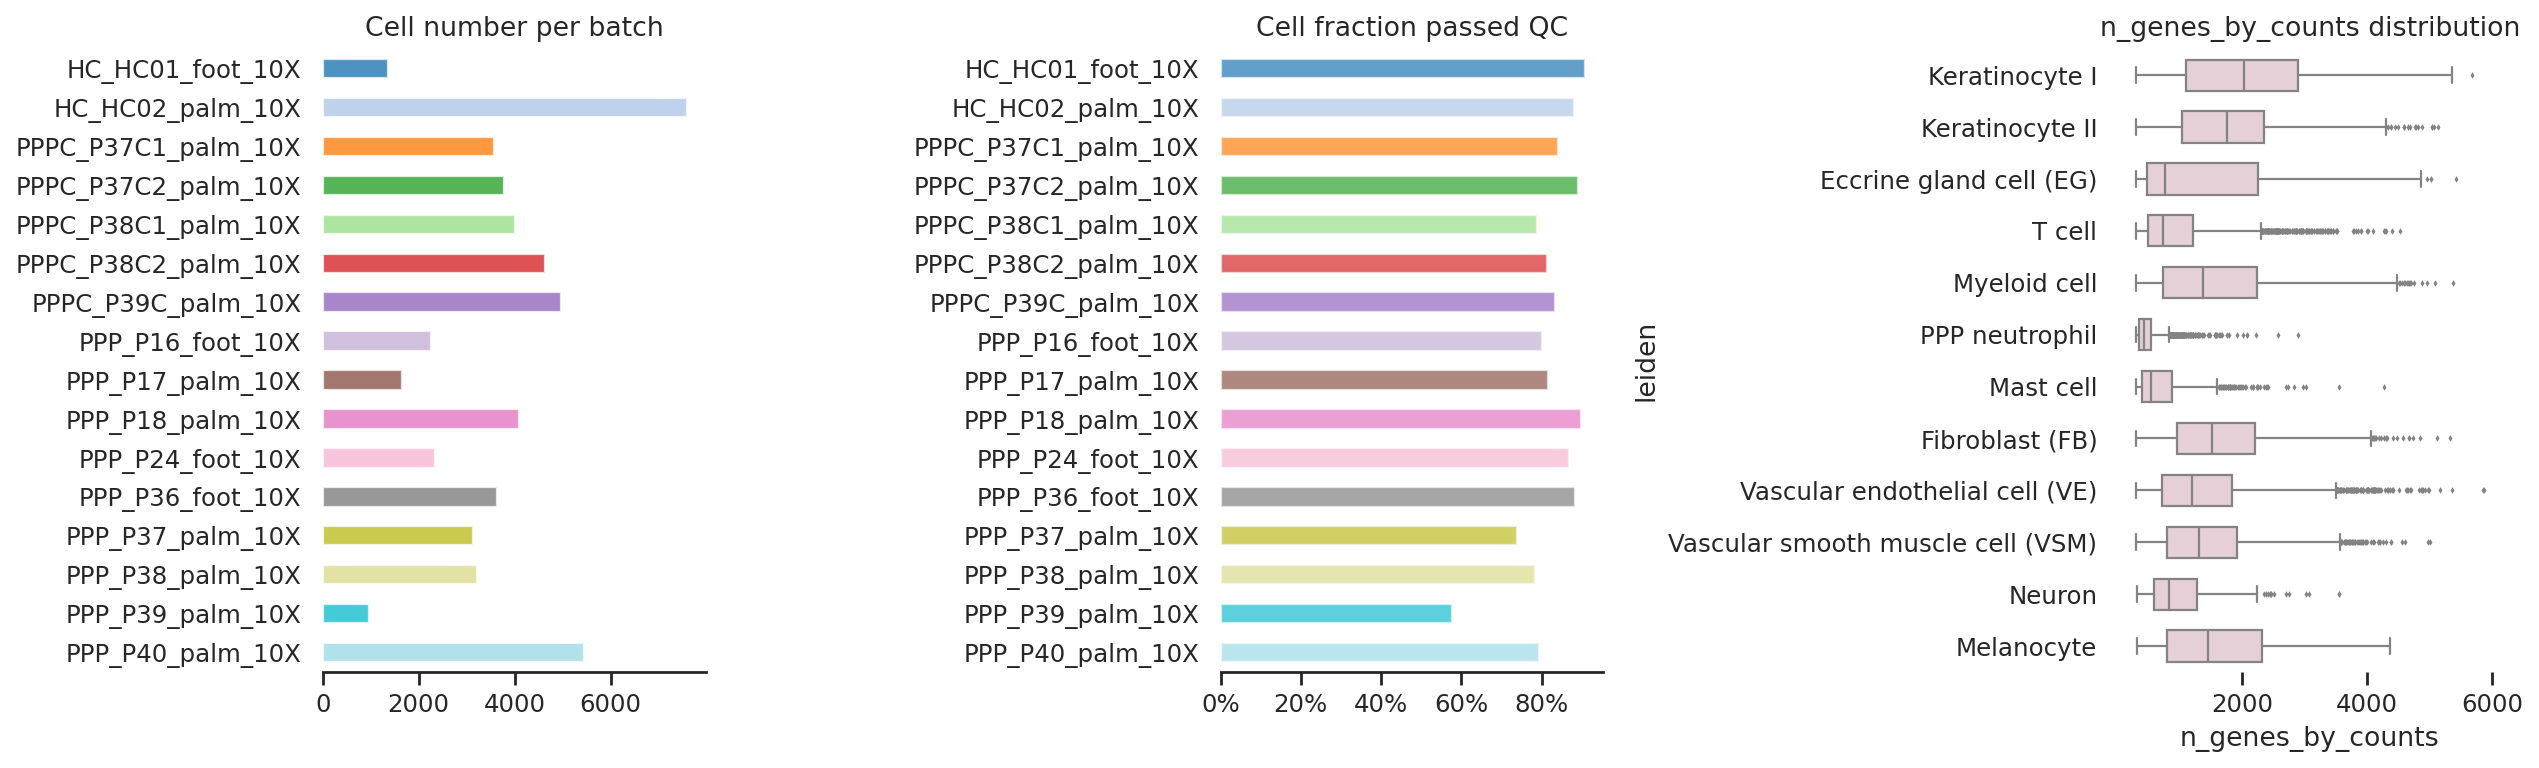

In [27]:
sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
adata_all.obs['batch'].value_counts().sort_index(ascending=False).plot.barh(ax=ax[0], color=adata_all.uns['batch_colors'][::-1], alpha=0.8)
ax[0].set_title('Cell number per batch')
sns.boxplot(y='leiden', x='n_genes_by_counts', data=adata_all.obs, color="#e8cdd7", ax=ax[2], width=0.6, fliersize=0.7, linewidth=1)

ax[2].set_title('n_genes_by_counts distribution')
df_raw_count_by_group = pd.DataFrame(adata_all.uns['batch_raw'], index=['raw_cell_number']).T
(adata_all.obs['batch'].value_counts() / df_raw_count_by_group['raw_cell_number']).sort_index(ascending=False).plot.barh(ax=ax[1], color=adata_all.uns['batch_colors'][::-1], alpha=0.7)
ax[1].set_title('Cell fraction passed QC')
# x axis label to percent
vals = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
fig.tight_layout()
sns.despine(left=True)
sns.despine(left=True, bottom=True, ax=ax[2])
ax[0].tick_params(top=False,bottom=True,left=False,right=False)
ax[1].tick_params(top=False,bottom=True,left=False,right=False)
plt.tick_params(top=False,bottom=True,left=False,right=False)
fig.savefig('figures/fig1/bar_qc_merge_ppp_with_control_cell_number.pdf', bbox_inches="tight")